In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("monthly_milk_production.csv", index_col="Date", parse_dates=True)

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [4]:
df.loc["1962-01":"1962-04"]

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656


In [5]:
df.loc["1962"].mean()

Production    615.75
dtype: float64

<Axes: xlabel='Date'>

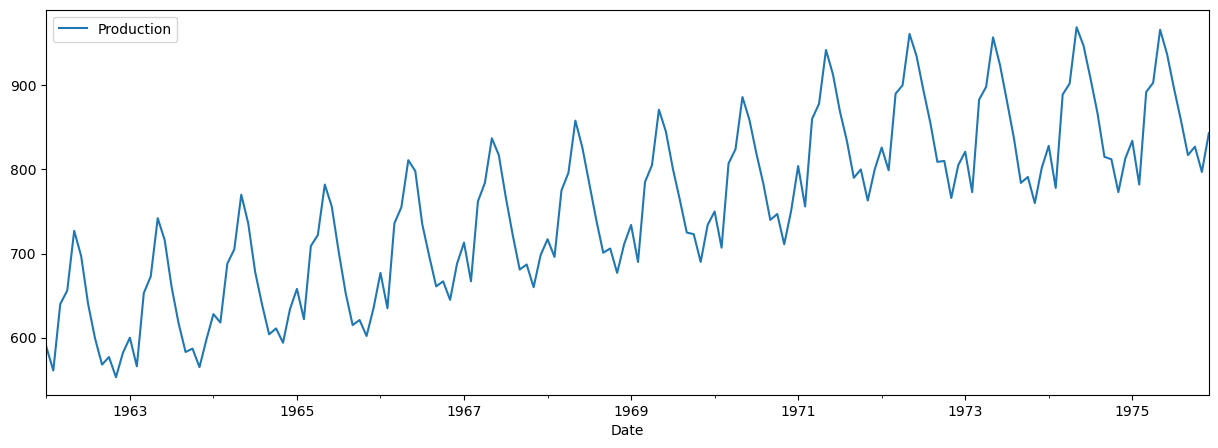

In [6]:
df.plot(figsize=(15,5))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
df.index.freq = "MS"

In [9]:
result = seasonal_decompose(df["Production"])

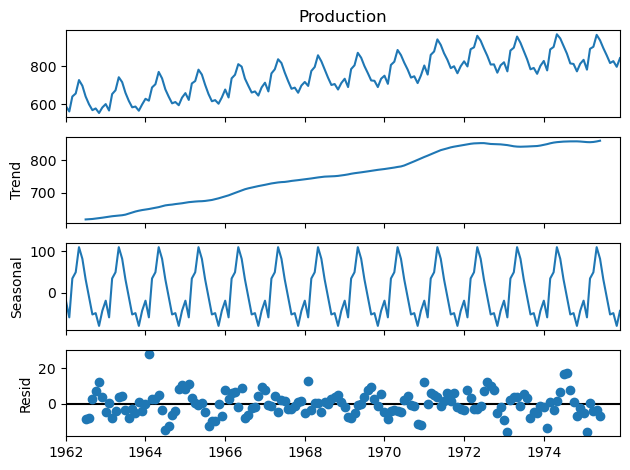

In [10]:
result.plot();

In [11]:
len(df)

168

In [12]:
train = df.iloc[:156]
test = df.iloc[156:]

In [13]:
len(train)

156

In [14]:
len(test)

12

In [15]:
train.iloc[0], train.iloc[-1]

(Production    589
 Name: 1962-01-01 00:00:00, dtype: int64,
 Production    813
 Name: 1974-12-01 00:00:00, dtype: int64)

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler()

In [19]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
scaled_train[:5]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923]])

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
n_input = 3

In [23]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
len(generator)

153

In [25]:
X, y = generator[0]
X.ravel(),y

(array([0.08653846, 0.01923077, 0.20913462]), array([[0.24759615]]))

In [26]:
X, y = generator[1]
X.ravel(),y

(array([0.01923077, 0.20913462, 0.24759615]), array([[0.41826923]]))

In [27]:
X.shape

(1, 3, 1)

In [28]:
df.head(3), df.tail(3)

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640,
             Production
 Date                  
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [29]:
n_input = [12]

In [37]:
#generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

# If n_input is a list, select a specific element or use a single integer value
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input[0], batch_size=1, start_index=0)


In [38]:
X,y = generator[0]
X.ravel(), y

(array([0.08653846, 0.01923077, 0.20913462, 0.24759615, 0.41826923,
        0.34615385, 0.20913462, 0.11057692, 0.03605769, 0.05769231,
        0.        , 0.06971154]),
 array([[0.11298077]]))

In [39]:
X.shape

(1, 12, 1)

In [40]:
from tensorflow.keras.models import Sequential

In [41]:
from tensorflow.keras.layers import Dense, LSTM

In [42]:
model = Sequential()

In [43]:
model.add(LSTM(1000, activation="relu", input_shape=(12, 1)))
model.add(Dense(1))

In [44]:
model.compile(optimizer="adam", loss="mse")

In [45]:
model.fit(generator, epochs=40)

Epoch 1/40

144/144 [==============================] - 29s 177ms/step - loss: 0.0378
Epoch 2/40
144/144 [==============================] - 25s 171ms/step - loss: 0.0155
Epoch 3/40
144/144 [==============================] - 24s 169ms/step - loss: 0.0081
Epoch 4/40
144/144 [==============================] - 24s 169ms/step - loss: 0.0043
Epoch 5/40
144/144 [==============================] - 24s 169ms/step - loss: 0.0036
Epoch 6/40
144/144 [==============================] - 24s 170ms/step - loss: 0.0037
Epoch 7/40
144/144 [==============================] - 25s 172ms/step - loss: 0.0029
Epoch 8/40
144/144 [==============================] - 25s 171ms/step - loss: 0.0026
Epoch 9/40
144/144 [==============================] - 25s 171ms/step - loss: 0.0032
Epoch 10/40
144/144 [==============================] - 25s 170ms/step - loss: 0.0029
Epoch 11/40
144/144 [==============================] - 25s 171ms/step - loss: 0.0037
Epoch 12/40
144/144 [==============================] - 25s 172ms/step - l

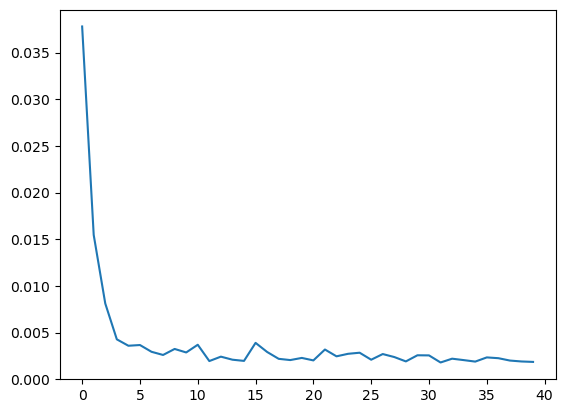

In [46]:
loss = model.history.history["loss"]
plt.plot(loss)

In [47]:
last_train_batch = scaled_train[-12:]

In [48]:
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [49]:
last_train_batch = last_train_batch.reshape((1,12,1))

In [50]:
model.predict(last_train_batch)

1/1 [==============================] - 1s 544ms/step


array([[0.6095123]], dtype=float32)

In [51]:
scaled_test[0]

array([0.67548077])

In [52]:
test_pred = []

first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape((1,12,1))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 70ms/step


In [53]:
test_pred

[array([0.6095123], dtype=float32),
 array([0.5167682], dtype=float32),
 array([0.7225397], dtype=float32),
 array([0.77497506], dtype=float32),
 array([0.9116585], dtype=float32),
 array([0.88262], dtype=float32),
 array([0.79617345], dtype=float32),
 array([0.7055495], dtype=float32),
 array([0.5946517], dtype=float32),
 array([0.57290673], dtype=float32),
 array([0.49749863], dtype=float32),
 array([0.5667917], dtype=float32)]

In [54]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [55]:
true_pred = scaler.inverse_transform(test_pred)

In [56]:
test["Predicted Production"] = true_pred

In [57]:
test.head()

,Production,Predicted Production
Date,,
1975-01-01,834,806.557129
1975-02-01,782,767.975578
1975-03-01,892,853.576525
1975-04-01,903,875.389626
1975-05-01,966,932.249947


<Axes: xlabel='Date'>

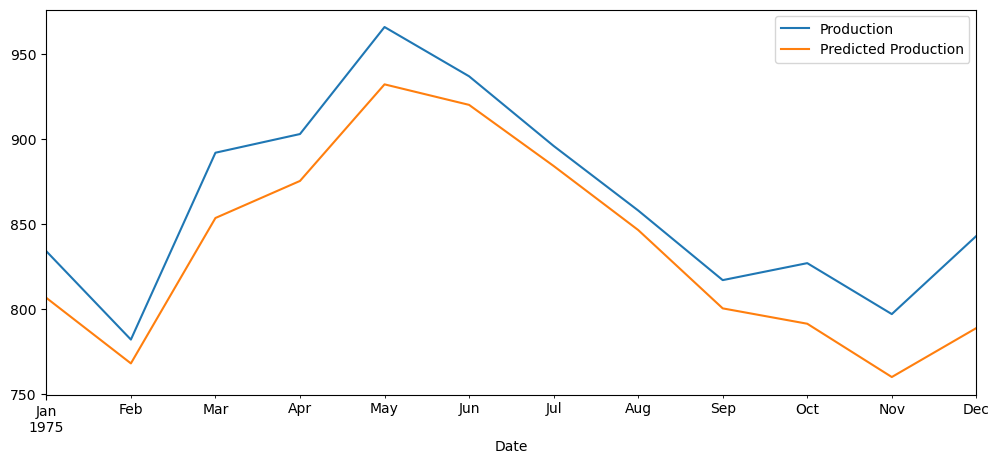

In [58]:
test.plot(figsize=(12,5))

In [59]:
from sklearn.metrics import mean_squared_error

In [60]:
rsme = np.sqrt(mean_squared_error(test["Production"], test["Predicted Production"]))

In [61]:
rsme

29.91924521254884